In [26]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint, quad, simps
from tqdm import tqdm
import itertools
import random
import warnings
warnings.filterwarnings('ignore')

#### Import datasets

In [2]:
#bulk fluorescence data
fluo_raw_1 = pd.read_csv('datasets/bulk_fluo_plate_1_triplicate.csv', index_col=0)
fluo_raw_2 = pd.read_csv('datasets/bulk_fluo_plate_2_triplicate.csv', index_col=0)
#od only data
od_raw_1 = pd.read_csv('datasets/od_plate_1_triplicate.csv', index_col=0)
od_raw_2 = pd.read_csv('datasets/od_plate_2_triplicate.csv', index_col=0)

In [3]:
incorrect = ['e16x30MjaKlbA', 'e26x30TerThyXS1', 'e34x30TvoVMA', 'e38x32NrdA2', 'e42x30MjaKlbA', 'e33',
            'e34x30SspGyrB.1', 'e38x30SspGyrB.1', 'e16x32gp418.1', 'e22x30gp418', 'e20x30MjaKlbA',
            'e17x32NrdA2.1', 'e34x33NrdA2.1', 'gfp_med', 'gfp_med.1', 'gfp_low', 'gfp_low.1',
            'e15', 'e17', 'e20', 'e26']
fluo = pd.concat([fluo_raw_1, fluo_raw_2], axis=1)
fluo = fluo.drop(incorrect, axis=1)
fluo = fluo.rename(columns={'e22x30gp418.1': 'e22x30gp418', 'e20x30MjaKlbA.1': 'e20x30MjaKlbA'})
od = pd.concat([od_raw_1, od_raw_2], axis=1)
od = od.drop(incorrect, axis=1)
od = od.rename(columns={'e22x30gp418.1': 'e22x30gp418', 'e20x30MjaKlbA.1': 'e20x30MjaKlbA'})

In [4]:
ecfs = list(set([i[:3] for i in fluo.columns.tolist()]))
inteins = list(set([i[6:] for i in fluo.columns.tolist()]))

In [5]:
inteins

['NrdA2',
 'STNpuSspS2',
 'MPMDnaB',
 'STIMPDH1',
 'STSspDnaX',
 'TerThyXS2',
 'TerThyXS1',
 'M86',
 'CthTer',
 'NpuSspS1LS2',
 'NrdJ1',
 'STsSspDnaX',
 'gp411',
 'SspGyrB',
 'STPhoRadA',
 'NpuSspS1',
 'TvoVMA',
 'gp418',
 'MjaKlbA',
 'STSspDnaXLS7',
 'SaPdpol',
 'M86LS1',
 'NpuSspS2']

e38x32gp418
e15x30SspGyrB
e34x30SspGyrB
e11x32NrdA2
e26x30STPhoRadA
e41x30STsSspDnaX
e16x30STsSspDnaX
e42x32STIMPDH1
e20x33NrdJ1
e22x33NrdJ1
e33x32STPhoRadA
e17x30STSspDnaXLS7
e32x32NrdJ1


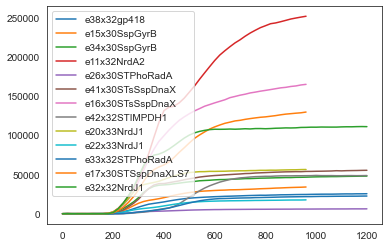

In [6]:
for e in ecfs:
    col = fluo[[i for i in fluo.columns.tolist() if i.startswith(e)]].max().sort_values().reset_index().iloc[-1]['index']
    plt.plot(fluo.index, fluo[col], label=col)
    print(col)
plt.legend()
plt.show()

e11x32NrdA2
e34x30STNpuSspS2
e17x30MPMDnaB
e42x32STIMPDH1
e17x30STSspDnaX
e38x30TerThyXS2
e16x30TerThyXS1
e16x32M86
e17x30CthTer
e17x30NpuSspS1LS2
e11x32NrdJ1
e16x30STsSspDnaX
e11x32gp411
e32x30SspGyrB
e11x32STPhoRadA
e38x30NpuSspS1
e17x30TvoVMA
e20x30gp418
e34x30MjaKlbA
e17x30STSspDnaXLS7
e17x30SaPdpol
e17x32M86LS1
e15x32NpuSspS2


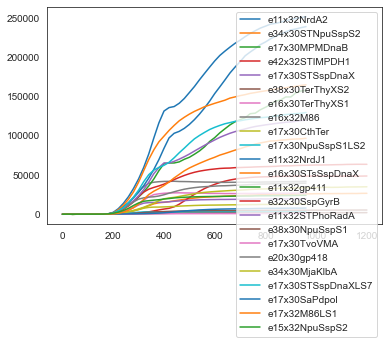

In [7]:
for n in inteins:
    col = fluo[[i for i in fluo.columns.tolist() if i[6:]==n]].max().sort_values().reset_index().iloc[-1]['index']
    plt.plot(fluo.index, fluo[col], label=col)
    print(col)
plt.legend()
plt.show()

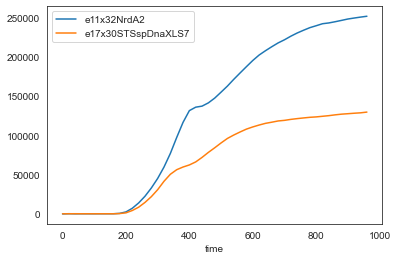

In [8]:
fluo[['e11x32NrdA2',  'e17x30STSspDnaXLS7']].plot()
plt.show()

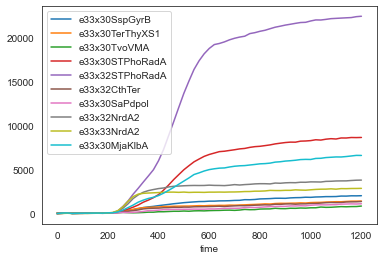

In [9]:
col = [i for i in fluo.columns.tolist() if i.startswith('e33')]
fluo[col].plot()
plt.show()

#### Select gates by manual inspection

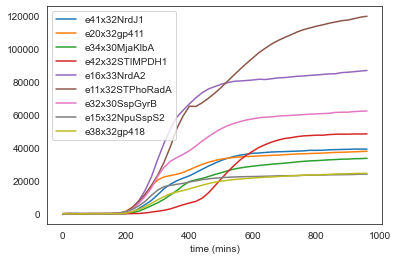

In [11]:
selected = ['e41x32NrdJ1', 'e20x32gp411', 'e34x30MjaKlbA', 'e42x32STIMPDH1',
           'e16x33NrdA2', 'e11x32STPhoRadA', 'e32x30SspGyrB', 'e15x32NpuSspS2', 'e38x32gp418']
#selected = ['e41x32NrdJ1', 'e20x32gp411', 'e34x30MjaKlbA', 'e42x32STIMPDH1',
#           'e16x33NrdA2', 'e11x32STPhoRadA', 'e32x30SspGyrB']
#selected = ['e11x32NrdA2', 'e15x32NpuSspS2', 'e16x30STsSspDnaX',
#            'e17x30STSspDnaXLS7', 'e20x30gp418', 'e22x33NrdJ1', 'e26x30STPhoRadA',
#            'e32x30SspGyrB', 'e33x30MjaKlbA', 'e34x30STNpuSspS2', 'e38x30NpuSspS1',
#            'e41x32NrdJ1', 'e42x32STIMPDH1']

fluo_selected = fluo[selected].dropna()
od_selected = od[selected].dropna()
num_traces = fluo_selected.shape[1]
fluo_selected.plot()
plt.xlabel('time (mins)')
plt.show()

#### Modeling OD

In [12]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

def od_inference(od):
    od_bounds = [(0, 0, 0), (1, 2, 0.1)]
    od_params = []
    od_t = od.index
    for idx in range(od.shape[1]):
        od_data = od[od.columns[idx]]
        opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
        od_params.append(opt)
    return od_params

od_params_selected = od_inference(od_selected)
len(od_params_selected)

9

### Modelling fluorescence

In [13]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper(t, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = syn_ECFn - (deg + gamma) * ECFn
        dECFc = syn_ECFc - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def fit_deg_stable_gfp(idx):
    
    f_data = fluo_selected.iloc[:,idx]
    f_t = fluo_selected.index
    title = fluo_selected.columns[idx]
    alpha, beta, c0 = od_params_selected[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    
    parameters = ['syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    init_guess = [1, 1, 1e-6, 1e-3, 1e2, 1e-2, 1, 2]
    gate_bounds_together = [np.array(init_guess)*0, np.array(init_guess)*100]
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, 4, extra, y0)
        return fit[3]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

In [14]:
f_df_deg, f_sim_deg, f_data_deg = zip(*[fit_deg_stable_gfp(idx) for idx in tqdm(range(len(od_params_selected)))])
len(f_df_deg)

100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


9

#### Define inference helper and fixed functions

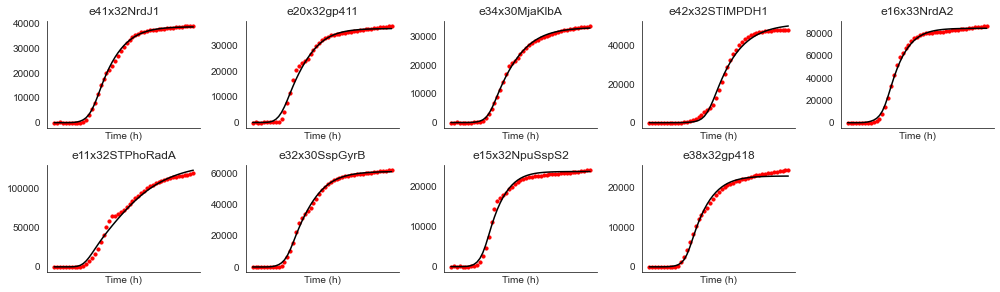

In [15]:
def compare_model_data(f_t, f_data, f_sim, ax):
    ax.scatter(f_t / 60, f_data, c='r', s=10)
    ax.plot(f_t / 60, f_sim, c='k')
    ax.set_xlabel('Time (h)')
    
def plot_parameters(f_df, bounds):
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(12, 1.5*(n_paras+1)))
    for i, ax in enumerate(axs):
        ax.errorbar(fluo_selected.columns, values[:,i], errors[:,i], fmt='.')
        #ax.set_ylim(bounds[0][i], bounds[1][i])
        ax.set_ylabel(parameters[i])
    plt.xticks(rotation=90)
    sns.despine()
    
def plot_comparisons(f_sim, f_data):
    fig, axs = plt.subplots(10, 5, sharex=True, sharey=False, figsize=(14, 20))
    f_t = f_data[0].index
    axr = axs.ravel()

    for i, ax in enumerate(axr):
        if i < num_traces:
            ax = axr[i]
            compare_model_data(f_t, f_data[i], f_sim[i], ax)
            ax.set_title(fluo_selected.columns[i])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
plot_comparisons(f_sim_deg, f_data_deg)

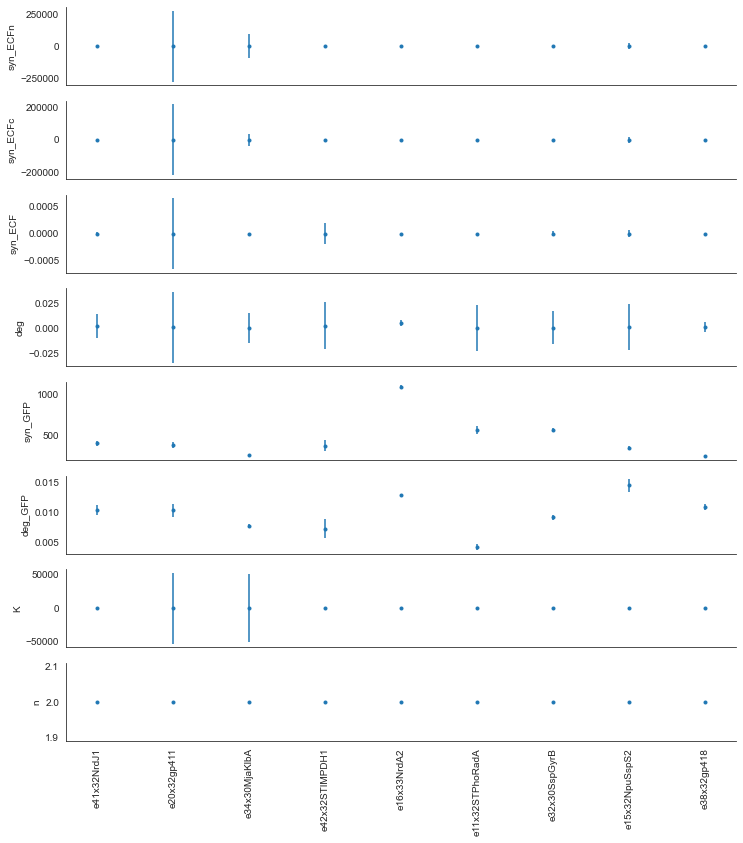

In [16]:
init_guess = [1e-6, 1e-3, 1e2, 1e-2, 2]
gate_bounds = [np.array(init_guess)*0, np.array(init_guess)*100]
plot_parameters(f_df_deg, gate_bounds)

### Layering the Models

In [17]:
class Gate:
    def __init__(self, name, gate_params, od_params, fluo_data, od_data):
        
        #metadata
        self.name = name
        
        #parameters
        self.syn_ECFn = gate_params[0]
        self.syn_ECFc = gate_params[1]
        self.syn_ECF = gate_params[2]
        self.deg = gate_params[3]
        self.syn_GFP = gate_params[4]
        self.deg_GFP = gate_params[5]
        self.K = gate_params[6]
        self.n = gate_params[7]
        self.alpha = od_params[0]
        self.beta = od_params[1]
        self.gamma = 0
        
        #initial states
        self.ECFn = 0
        self.ECFc = 0
        self.ECF = 0
        self.GFP = 0
        self.OD = od_params[2]
        
        #derivative states
        self.dECFn = 0
        self.dECFc = 0
        self.dECF = 0
        self.dGFP = 0
        self.dOD = 0
        
        #connection
        self.connection = None
        
        #data
        self.fluo_data = fluo_data
        self.od_data = od_data
        
    def get_params(self):
        return [self.syn_ECFn, self.syn_ECFc, self.syn_ECF, self.deg, self.syn_GFP, self.deg_GFP, self.K, self.n, self.alpha, self.beta]
    
    def get_init_states(self):
        return [self.ECFn, self.ECFc, self.ECF, self.GFP, self.OD]
    
class Connection:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        self.name = name
        self.input1 = input1
        self.input2 = input2
        self.output = output
        self.level = level #0: input, 1: intermediate, 2:output
        self.index = index
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit:
    def __init__(self, fluo, od, gate_params, od_params, schema, arrangement):
        
        #inducers
        self.inducers = [1] * 8
        
        #gate
        self.gates = []
        for i in arrangement:
            self.gates.append(Gate('g' + str(i), gate_params[i], od_params[i], fluo.iloc[:,i], od.iloc[:,i]))
        
        self.connections = [
            Connection('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4),
            Connection('c2', self.inducers[2], self.inducers[3], None, 0, 1, 2, 3, 4),
            Connection('c3', self.inducers[4], self.inducers[5], None, 0, 4, 0, 1, 6),
            Connection('c4', self.inducers[6], self.inducers[7], None, 0, 3, 6, 7, 5),
            Connection('c5', self.gates[0], self.gates[1], None, 1, 4, 0, 1, 6),
            Connection('c6', self.gates[2], self.gates[3], None, 1, 5, 2, 3, 6),
            Connection('c7', self.gates[4], self.gates[5], None, 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)

In [18]:
def hill_equation2(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper2(t, circuit):
    
    y0 = np.array([g.get_init_states() for g in circuit.gates]).ravel()
    
    def gate_model2(y, t):
        
        yi = np.reshape(y, (-1, 5))
        yn = []
        
        for i, g in enumerate(circuit.gates):
            
            g.ECFn, g.ECFc, g.ECF, g.GFP, g.OD = yi[i]
        
            #growth
            g.gamma = growth_rate(t, g.OD, g.alpha, g.beta)
            g.dOD = g.gamma * g.OD
            
            #level 0 (input)
            if g.connection.level==0:
                
                g.dECFn = g.syn_ECFn * g.connection.input1 - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * g.connection.input2 - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 1 (middle)
            elif g.connection.level==1:

                input1 = g.connection.input1
                input2 = g.connection.input2
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                #g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 2 (output)
            elif g.connection.level==2:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                g.dGFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg_GFP + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
        
        return np.array(yn).ravel()
    
    solution = odeint(gate_model2, y0, t)
    return solution.transpose()

### Exhaustive Search

In [19]:
gate_params_selected = [par['Value'] for par in f_df_deg]
all_arr = [list(a) for a in list(itertools.permutations(np.arange(len(gate_params_selected)), 7))]
len(all_arr)

181440

In [15]:
gate_params_selected = [par['Value'] for par in f_df_deg]
#arr = np.arange(len(gate_params_selected))
#np.random.shuffle(arr)
#print(arr)
f_t = fluo_selected.index

results = []
for i, arr in enumerate(tqdm(all_arr)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    dyn = gfp.max() - gfp.min()
    results.append((dyn, arr))

100%|██████████| 5040/5040 [03:19<00:00, 25.29it/s]


 20%|██        | 2/10 [00:00<00:00, 17.17it/s]

Best result 111984.93874136555


100%|██████████| 10/10 [00:00<00:00, 22.20it/s]


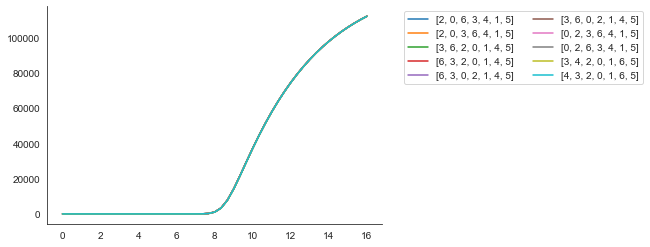

In [16]:
best_results = sorted(results, reverse=True)[:10]
print('Best result', best_results[0][0])
for i, res in enumerate(tqdm(best_results)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, res[1])
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    plt.plot(gfp, label= res[1])
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

### Genetic Algorithm

In [20]:
len(selected)

9

In [30]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluo_selected.index
    fitness = []
    
    for i, p in enumerate(pop):
        circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        model = gate_wrapper2(f_t, circuit)
        gfp = pd.Series(model[33], index=f_t/60)
        #f = gfp.max()-gfp.min()
        #f = simps(model[33])     #area under the curve
        f, _ = quad(gate_wrapper2, 0, 600, args=(circuit,))
        fitness.append(f)
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=50, candidates=len(selected), length=7)
#result

  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: diff requires input that is at least one dimensional

[8 2 6 0 7 1 5]
114632.78901194895


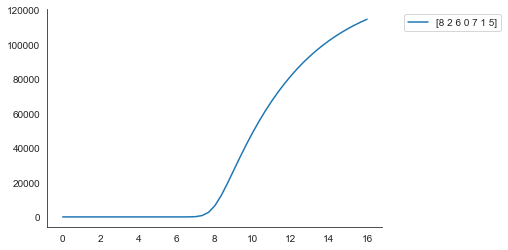

In [27]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

[6 8 2 5 7 1 4]
84506.06013324176


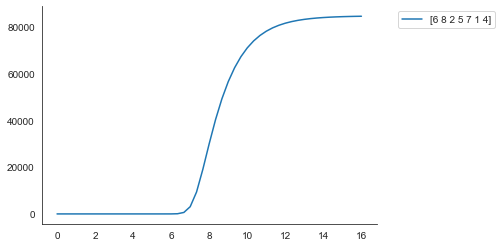

In [29]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

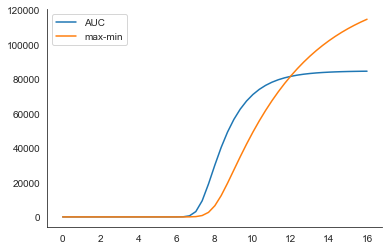

In [37]:
arr1 = [6, 8, 2, 5, 7, 1, 4]
arr2 = [8, 2, 6, 0, 7, 1, 5]
f_t = fluo_selected.index
for ar in pop_copy[:1]:
    circuit1 = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr1)
    model1 = gate_wrapper2(f_t, circuit1)
    gfp1 = pd.Series(model1[33], index=f_t/60)
    plt.plot(gfp1, label='AUC')
    
    circuit2 = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr2)
    model2 = gate_wrapper2(f_t, circuit2)
    gfp2 = pd.Series(model2[33], index=f_t/60)
    plt.plot(gfp2, label='max-min')
plt.legend()
sns.despine()
plt.show()

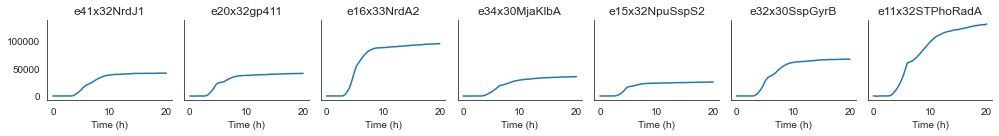

In [18]:
final_asg = fluo_selected[[fluo_selected.columns[j] for j in ga_arrangement]]
num_col = 7
num_row = 1
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        ax.plot(final_asg.index / 60, final_asg.iloc[:, i])
        ax.set_title(final_asg.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

100%|██████████| 20/20 [02:25<00:00,  7.28s/it]


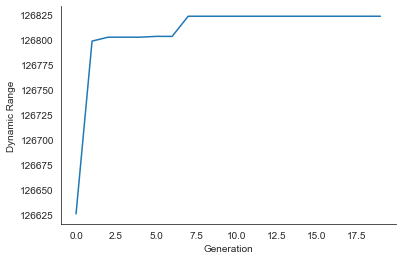

In [19]:
def geneticAlgorithmPlot(pop_copy, popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = [i for i in pop_copy]
    progress = []
    progress.append(rankIndiv(pop)[0][1])
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
        progress.append(rankIndiv(pop)[0][1])
    return progress
    
progress = geneticAlgorithmPlot(pop_copy, popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(selected), length=7)
plt.figure(figsize=[6, 4])
plt.plot(progress[:20])
plt.ylabel('Dynamic Range')
plt.xlabel('Generation')
sns.despine()
plt.show()